In [2]:
import pandas as pd

In [3]:
titanic_df = pd.read_csv("small.csv")
len(titanic_df.columns)

8

In [4]:
for column in titanic_df.columns:
    print(f"{column}: {titanic_df[column].unique()}")

age: [1 2 3]
portembarked: [1 2 3]
fare: [1 2 3]
numparentschildren: [1 2 3]
passengerclass: [1 2 3]
sex: [1 2]
numsiblings: [1 2 3]
survived: [1 2]


In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
from utils.graph import Node, DAG

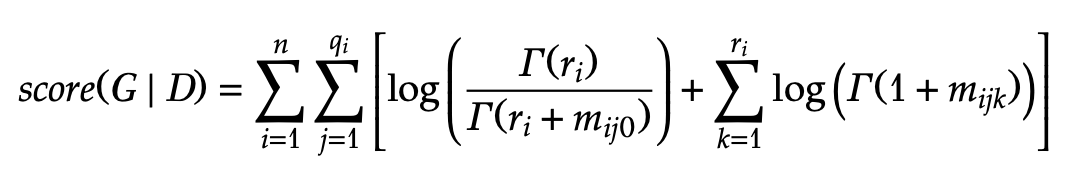
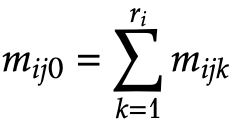

Our goal is to implement this function. Lets make sure we have everything defined:
- G = the graph
- D = the data
- n = the number of variables
- q_i = the number of possible values of the parents of Xi, which is 2^k if there are k parents and all our variables are binary
- r_i = the number of possible values our Xi variable can take
- m_ijk = the number of times in our data that the variable Xi takes the value k, and the parents of Xi take the jth configuration instantation 

In [7]:
from itertools import product
from math import log
from scipy.special import loggamma

def bayesian_dirichilet_score(self, data: pd.DataFrame):
    total_sum = 0
    variable_unique_counts = {variable: data[variable].unique() for variable in data.columns}

    # For each node we need to iterate over all the possible configurations of the parents
    for node in self.nodes:
        possible_values = variable_unique_counts[node.variable]
        
        parents = node.prev
        parent_variables = [parent.variable for parent in parents]
        parent_configurations = generate_parent_configurations(node, variable_unique_counts)
        
        r_i = len(possible_values)
        
        left_sum = 0
        # The possible configurations are generated via the cartesian product
        for config in parent_configurations:
            m_ij0 = 0

            # Build the DataFrame query that matches our parent configuration
            base_string = ""
            for (key,value) in zip(parent_variables, config):
                base_string += f"{key} == {value} & "

            right_sum = 0
            for k in possible_values:
                query_string = base_string + f"{node.variable} == {k}"
                # Find all observations that have our parent configuration and a value of k for this node
                m_ijk = len(data.query(query_string))
                # We keep track of m_ij0 here to reduce the DataFrame queries
                # Count all instances of this parent configuration across all values of Xi
                m_ij0 += m_ijk
                right_sum += loggamma(1 + m_ijk)

            left_sum += (loggamma(r_i) - loggamma(r_i + m_ij0)) + right_sum

        total_sum += left_sum
    return total_sum
    
def generate_parent_configurations(node: Node, unique_counts: dict):
    parents = node.prev
    possible_values = [unique_counts[parent.variable] for parent in parents]
    return list(product(*possible_values))

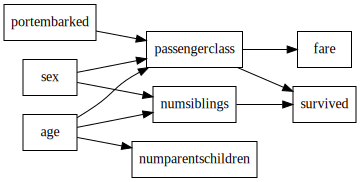

In [55]:
edge_list = [
    ('age','numparentschildren'),
    ('age','numsiblings'), 
    ('age','passengerclass'),
    ('sex','passengerclass'),
    ('sex','numsiblings'),
    ('passengerclass','fare'),
    ('passengerclass','survived'),
    ('portembarked','passengerclass'),
    ('numsiblings','survived')
]

hand_picked_nodes = [Node(variable=col, prev=[]) for col in titanic_df.columns]

for edge in edge_list:
    node_name = edge[1]
    parent_name = edge[0]
    child = None
    parent = None
    for node in hand_picked_nodes:
        if (node.variable == node_name):
            child = node
            break
    for node in hand_picked_nodes:
        if (node.variable == parent_name):
            parent = node
            break
    if (child != None and parent != None):
        child.add_prev(parent)

hand_made_dag = DAG(nodes=hand_picked_nodes, randomize=False)
hand_made_dag.draw_dot_from_digraph()

In [10]:
bayesian_dirichilet_score(hand_made_dag, titanic_df)

-4076.0855069184418

In [11]:
from utils.graph import HillClimbing

-4032.6119571830095
-1399.2692491668179


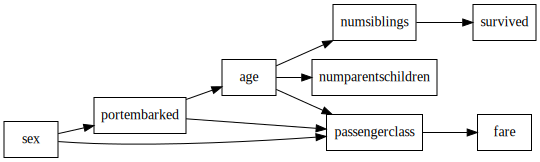

In [53]:
print(hand_made_dag.bayesian_dirichilet_score(titanic_df))
searcher = HillClimbing(hand_made_dag, titanic_df, max_iteration=5)
best_handmade, best_handmade_score = searcher.solve()
print(best_handmade_score)
best_handmade.draw_dot_from_digraph()

-3597.279282339381
-1394.073809314819


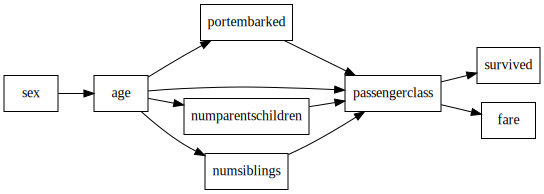

In [56]:
print(hand_made_dag.bayesian_dirichilet_score_fast(titanic_df))
searcher = HillClimbing(hand_made_dag, titanic_df, max_iteration=1000)
best_handmade, best_handmade_score = searcher.solve()
print(best_handmade_score)
best_handmade.draw_dot_from_digraph()

In [14]:
import numpy as np

In [15]:
def collect_state_names(variable):
    states = sorted(list(titanic_df.loc[:, variable].dropna().unique()))
    return states

state_names = {
    var: collect_state_names(var) for var in titanic_df.columns
}

In [16]:
state_names

{'age': [1, 2, 3],
 'portembarked': [1, 2, 3],
 'fare': [1, 2, 3],
 'numparentschildren': [1, 2, 3],
 'passengerclass': [1, 2, 3],
 'sex': [1, 2],
 'numsiblings': [1, 2, 3],
 'survived': [1, 2]}

In [17]:
variable = ['passengerclass']
parents = ['numparentschildren','numsiblings','age']

In [18]:
configurations = titanic_df.groupby(variable + parents).size().unstack(parents)

In [19]:
configurations

numparentschildren      1                             2                     3  \
numsiblings             1                  2          1           2    3    1   
age                     1      2     3     1    2     1     2     1    2    2   
passengerclass                                                                  
1                   167.0  245.0   7.0  12.0  5.0  11.0  10.0  18.0  7.0  9.0   
2                    29.0  135.0  28.0   NaN  NaN  12.0   5.0   3.0  NaN  NaN   
3                    55.0   99.0  11.0   NaN  1.0  12.0   5.0   NaN  NaN  NaN   

numparentschildren    2    3  
numsiblings           1    1  
age                   3    3  
passengerclass                
1                   NaN  NaN  
2                   1.0  1.0  
3                   1.0  NaN

In [20]:
row_index = state_names['passengerclass']
parents_states = [state_names[parent] for parent in parents]
column_index = pd.MultiIndex.from_product(parents_states, names=parents)
state_counts = configurations.reindex(
    index=row_index, columns=column_index
).fillna(0)

In [21]:
state_counts

numparentschildren      1                                                 2  \
numsiblings             1                  2              3               1   
age                     1      2     3     1    2    3    1    2    3     1   
passengerclass                                                                
1                   167.0  245.0   7.0  12.0  5.0  0.0  0.0  0.0  0.0  11.0   
2                    29.0  135.0  28.0   0.0  0.0  0.0  0.0  0.0  0.0  12.0   
3                    55.0   99.0  11.0   0.0  1.0  0.0  0.0  0.0  0.0  12.0   

numparentschildren  ...         3                                          
numsiblings         ...    3    1              2              3            
age                 ...    3    1    2    3    1    2    3    1    2    3  
passengerclass      ...                                                    
1                   ...  0.0  0.0  9.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2                   ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
3                   ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 27 columns]

In [22]:
state_counts.shape[1]

27

In [23]:
counts = np.asarray(state_counts)

In [24]:
print(counts)

[[167. 245.   7.  12.   5.   0.   0.   0.   0.  11.  10.   0.  18.   0.
    0.   0.   7.   0.   0.   9.   0.   0.   0.   0.   0.   0.   0.]
 [ 29. 135.  28.   0.   0.   0.   0.   0.   0.  12.   5.   1.   3.   0.
    0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.]
 [ 55.  99.  11.   0.   1.   0.   0.   0.   0.  12.   5.   1.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]


In [25]:
print(counts +1 )

[[168. 246.   8.  13.   6.   1.   1.   1.   1.  12.  11.   1.  19.   1.
    1.   1.   8.   1.   1.  10.   1.   1.   1.   1.   1.   1.   1.]
 [ 30. 136.  29.   1.   1.   1.   1.   1.   1.  13.   6.   2.   4.   1.
    1.   1.   1.   1.   1.   1.   2.   1.   1.   1.   1.   1.   1.]
 [ 56. 100.  12.   1.   2.   1.   1.   1.   1.  13.   6.   2.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]]


In [26]:
config_sums = np.sum(counts, axis=0)
config_sums

array([251., 479.,  46.,  12.,   6.,   0.,   0.,   0.,   0.,  35.,  20.,
         2.,  21.,   0.,   0.,   0.,   7.,   0.,   0.,   9.,   1.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [27]:
gamma_sums = loggamma(counts + 1)
gamma_sums

array([[ 691.18340111, 1106.47816936,    8.52516136,   19.9872145 ,
           4.78749174,    0.        ,    0.        ,    0.        ,
           0.        ,   17.50230785,   15.10441257,    0.        ,
          36.39544521,    0.        ,    0.        ,    0.        ,
           8.52516136,    0.        ,    0.        ,   12.80182748,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ],
       [  71.25703897,  530.58428829,   67.88974314,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,   19.9872145 ,    4.78749174,    0.        ,
           1.79175947,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ],
       [ 168.32744545,  359.13420537,   17.50230785,    0.        ,
        

In [28]:
gamma_config_sums = np.sum(gamma_sums, axis=0, dtype=float)
gamma_config_sums

array([ 930.76788553, 1996.19666302,   93.91721234,   19.9872145 ,
          4.78749174,    0.        ,    0.        ,    0.        ,
          0.        ,   57.47673684,   24.67939606,    0.        ,
         38.18720468,    0.        ,    0.        ,    0.        ,
          8.52516136,    0.        ,    0.        ,   12.80182748,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ])

In [29]:
for (sum, loggamma_sum) in zip(config_sums, gamma_config_sums):
    print(sum)
    print(loggamma_sum)

251.0
930.7678855300064
479.0
1996.1966630218094
46.0
93.91721234412084
12.0
19.987214495661885
6.0
4.787491742782046
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
35.0
57.47673683719766
20.0
24.679396058639608
2.0
0.0
21.0
38.18720467726111
0.0
0.0
0.0
0.0
0.0
0.0
7.0
8.525161361065415
0.0
0.0
0.0
0.0
9.0
12.801827480081469
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [30]:
state_count_data = titanic_df.loc[:, 'sex'].value_counts()

state_counts = (
    state_count_data.reindex(state_names['sex'])
    .fillna(0)
    .to_frame()
)

state_counts

,sex
1,577
2,312


In [57]:
from itertools import product
from math import log
from scipy.special import loggamma

def bayesian_dirichilet_score_fast(self, data: pd.DataFrame):
    
    def collect_state_names(variable):
        states = sorted(list(data.loc[:, variable].dropna().unique()))
        return states

    state_names = {
        var: collect_state_names(var) for var in data.columns
    }

    total_sum = 0
    for node in self.nodes:
        variable = node.variable
        parents = [parent.variable for parent in node.prev]

        print(f"checking variable: {variable} and parents: {parents}")
        
        configurations = data.groupby([variable] + parents).size().unstack(parents)

        parents_states = [state_names[parent] for parent in parents]
        
        if len(parents_states) == 0:
            state_count_data = data.loc[:, variable].value_counts()

            state_counts = (
                state_count_data.reindex(state_names[variable])
                .fillna(0)
                .to_frame()
            )
        else:
            row_index = state_names[variable]
            column_index = pd.MultiIndex.from_product(parents_states, names=parents)
            state_counts = configurations.reindex(
                index=row_index, columns=column_index
            ).fillna(0)

        r_i = len(state_names[variable])
        
        counts = np.asarray(state_counts)
        
        log_counts = loggamma(counts + 1)
        loggamma_sum_per_configuration = np.sum(log_counts, axis=0, dtype=float)
        sum_per_configuration = np.sum(counts, axis=0)

        left_sum = 0
        for (sum, loggamma_sum) in zip(sum_per_configuration, loggamma_sum_per_configuration):
            left_sum += loggamma(r_i) - loggamma(r_i + sum) + loggamma_sum

        total_sum += left_sum
    return total_sum

In [32]:
bayesian_dirichilet_score_fast(hand_made_dag, titanic_df)

-3640.7528320748143

In [33]:
wine_df = pd.read_csv("medium.csv")

In [34]:
wine_df.columns

Index(['fixedacidity', 'volatileacidity', 'citricacid', 'residualsugar',
       'chlorides', 'freesulfurdioxide', 'totalsulfurdioxide', 'density', 'ph',
       'sulphates', 'alcohol', 'quality'],
      dtype='object')

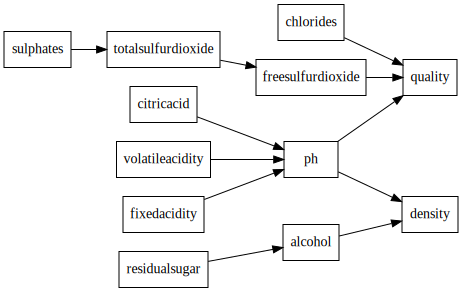

In [35]:
edge_list = [
    ('fixedacidity','ph'),
    ('volatileacidity','ph'), 
    ('citricacid','ph'),
    ('ph','quality'),
    ('ph','density'),
    ('residualsugar','alcohol'),
    ('alcohol','density'),
    ('denisty','quality'),
    ('sulphates','totalsulfurdioxide'),
    ('totalsulfurdioxide','freesulfurdioxide'),
    ('freesulfurdioxide','quality'),
    ('chlorides','quality')
]

hand_picked_nodes = [Node(variable=col, prev=[]) for col in wine_df.columns]

for edge in edge_list:
    node_name = edge[1]
    parent_name = edge[0]
    child = None
    parent = None
    for node in hand_picked_nodes:
        if (node.variable == node_name):
            child = node
            break
    for node in hand_picked_nodes:
        if (node.variable == parent_name):
            parent = node
            break
    if (child != None and parent != None):
        child.add_prev(parent)

hand_made_dag = DAG(nodes=hand_picked_nodes, randomize=False)
hand_made_dag.draw_dot_from_digraph()

-31993.92737296222
-926.9224923965448


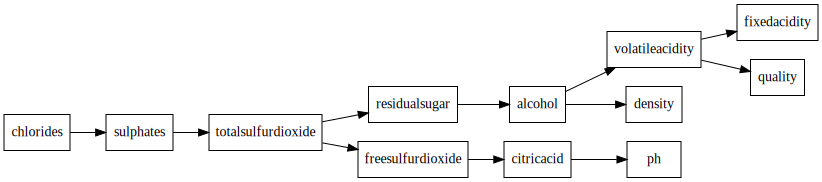

In [41]:
print(hand_made_dag.bayesian_dirichilet_score_fast(wine_df))
searcher = HillClimbing(hand_made_dag, wine_df, max_iteration=2000)
best_handmade, best_handmade_score = searcher.solve()
print(best_handmade_score)
best_handmade.draw_dot_from_digraph()

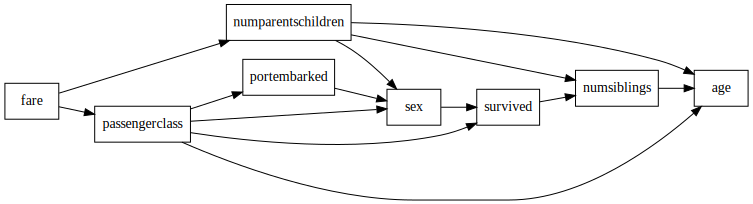

In [58]:
edges = [('numparentschildren', 'age'), ('numparentschildren', 'sex'), ('passengerclass', 'age'), ('passengerclass', 'survived'), ('portembarked', 'sex'), ('fare', 'passengerclass'), ('numparentschildren', 'numsiblings'), ('numsiblings', 'age'), ('sex', 'survived'), ('fare', 'numparentschildren'), ('passengerclass', 'sex'), ('survived', 'numsiblings'), ('passengerclass', 'portembarked')]

hand_picked_nodes = [Node(variable=col, prev=[]) for col in titanic_df.columns]

for edge in edges:
    node_name = edge[1]
    parent_name = edge[0]
    child = None
    parent = None
    for node in hand_picked_nodes:
        if (node.variable == node_name):
            child = node
            break
    for node in hand_picked_nodes:
        if (node.variable == parent_name):
            parent = node
            break
    if (child != None and parent != None):
        child.add_prev(parent)

hand_made_dag = DAG(nodes=hand_picked_nodes, randomize=False)
hand_made_dag.draw_dot_from_digraph()

-1967.6633840085528
-1250.9548906916666


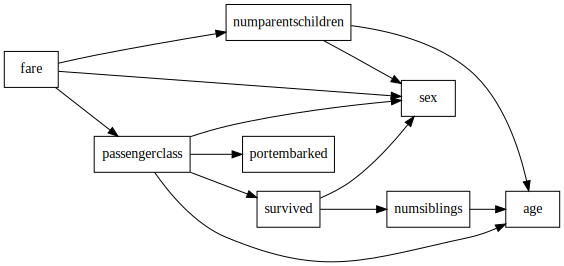

In [59]:
print(hand_made_dag.bayesian_dirichilet_score_fast(titanic_df))
searcher = HillClimbing(hand_made_dag, titanic_df, max_iteration=1000)
best_handmade, best_handmade_score = searcher.solve()
print(best_handmade_score)
best_handmade.draw_dot_from_digraph()